# MMP9 Inhibitor Classification

## Business Understanding

## Data Understanding

## Data Preparation

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier

from lazypredict.Supervised import LazyClassifier

from chembl_webresource_client.new_client import new_client

/Users/cindyreiner/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [8]:
%%script echo skipping
target = new_client.target
target_query = target.search('acetylcholine receptor M2')
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'P08172', 'xref_name': None, 'xre...",Homo sapiens,Muscarinic acetylcholine receptor M2,28.0,False,CHEMBL211,"[{'accession': 'P08172', 'component_descriptio...",SINGLE PROTEIN,9606.0
1,"[{'xref_id': 'P06199', 'xref_name': None, 'xre...",Sus scrofa,Muscarinic acetylcholine receptor M2,28.0,False,CHEMBL4781,"[{'accession': 'P06199', 'component_descriptio...",SINGLE PROTEIN,9823.0
2,[],Homo sapiens,Muscarinic acetylcholine receptors; M2 & M3,28.0,False,CHEMBL2095187,"[{'accession': 'P20309', 'component_descriptio...",SELECTIVITY GROUP,9606.0
3,[],Homo sapiens,Muscarinic acetylcholine receptors; M1 & M2,28.0,False,CHEMBL2095219,"[{'accession': 'P11229', 'component_descriptio...",SELECTIVITY GROUP,9606.0
4,[],Homo sapiens,Muscarinic acetylcholine receptor M2 and M4,28.0,False,CHEMBL2111445,"[{'accession': 'P08173', 'component_descriptio...",SELECTIVITY GROUP,9606.0
...,...,...,...,...,...,...,...,...,...
2160,[],Homo sapiens,F-box-like/WD repeat-containing protein TBL1XR...,1.0,False,CHEMBL4523746,"[{'accession': 'P41182', 'component_descriptio...",PROTEIN-PROTEIN INTERACTION,9606.0
2161,[],Homo sapiens,26S proteasome,0.0,False,CHEMBL2364701,"[{'accession': 'Q99460', 'component_descriptio...",PROTEIN COMPLEX,9606.0
2162,[],Homo sapiens,Aminopeptidase,0.0,False,CHEMBL3831223,"[{'accession': 'P15144', 'component_descriptio...",PROTEIN FAMILY,9606.0
2163,[],Homo sapiens,80S Ribosome,0.0,False,CHEMBL3987582,"[{'accession': 'P08865', 'component_descriptio...",PROTEIN NUCLEIC-ACID COMPLEX,9606.0


In [10]:
%%script echo skipping
selected_target = targets['target_chembl_id'][0]
selected_target

'CHEMBL211'

In [11]:
%%script echo skipping
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target)
df = pd.DataFrame.from_dict(res)
df

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,32092,[],CHEMBL751169,Antimuscarinic activity against muscarinic ace...,B,None,None,BAO_0000587,BAO_0000357,...,Homo sapiens,Muscarinic acetylcholine receptor M2,9606,None,None,Kb,nM,UO_0000065,None,4.13
1,None,32095,[],CHEMBL751169,Antimuscarinic activity against muscarinic ace...,B,None,None,BAO_0000587,BAO_0000357,...,Homo sapiens,Muscarinic acetylcholine receptor M2,9606,None,None,Kb,nM,UO_0000065,None,11.6
2,None,32139,[],CHEMBL752966,Agonistic efficacy in human m2 muscarinic rece...,F,None,None,BAO_0003036,BAO_0000219,...,Homo sapiens,Muscarinic acetylcholine receptor M2,9606,None,None,ED50,nM,UO_0000065,None,4.2
3,None,32140,[],CHEMBL752964,Agonistic efficacy in human m2 muscarinic rece...,F,None,None,BAO_0000179,BAO_0000219,...,Homo sapiens,Muscarinic acetylcholine receptor M2,9606,None,None,CCh,%,UO_0000187,None,130.0
4,None,33319,[],CHEMBL752966,Agonistic efficacy in human m2 muscarinic rece...,F,None,None,BAO_0003036,BAO_0000219,...,Homo sapiens,Muscarinic acetylcholine receptor M2,9606,None,None,ED50,nM,UO_0000065,None,28.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6346,Not Active,20143644,"[{'comments': None, 'relation': None, 'result_...",CHEMBL4508871,Muscarinic M2 Eurofins-Panlabs radioligand bin...,B,None,None,BAO_0000201,BAO_0000357,...,Homo sapiens,Muscarinic acetylcholine receptor M2,9606,None,None,% inhibition,%,UO_0000187,None,-4.0
6347,Not Active,20144006,"[{'comments': None, 'relation': None, 'result_...",CHEMBL4508871,Muscarinic M2 Eurofins-Panlabs radioligand bin...,B,None,None,BAO_0000201,BAO_0000357,...,Homo sapiens,Muscarinic acetylcholine receptor M2,9606,None,None,% inhibition,%,UO_0000187,None,9.0
6348,Not Active,20144412,"[{'comments': None, 'relation': None, 'result_...",CHEMBL4508871,Muscarinic M2 Eurofins-Panlabs radioligand bin...,B,None,None,BAO_0000201,BAO_0000357,...,Homo sapiens,Muscarinic acetylcholine receptor M2,9606,None,None,% inhibition,%,UO_0000187,None,-2.0
6349,Not Active,20145434,"[{'comments': None, 'relation': None, 'result_...",CHEMBL4507836,GPCRScan assay: inhibition of M2,B,None,None,BAO_0000201,BAO_0000357,...,Homo sapiens,Muscarinic acetylcholine receptor M2,9606,None,None,% Inhibition,%,UO_0000187,None,5.17548


In [12]:
%%script echo skipping
df['standard_type'].value_counts()

Ki                                                     2518
IC50                                                   1440
Inhibition                                              483
Activity                                                276
EC50                                                    273
Kb                                                      211
Kd                                                      161
pKb                                                     141
Cooperativity                                            84
Log 1/M                                                  72
Emax                                                     66
pKB                                                      56
Efficacy                                                 55
Affinity                                                 48
Ratio                                                    44
Imax                                                     38
Intrinsic activity                      

In [25]:
%%script echo skipping
df['standard_value']=pd.to_numeric(df['standard_value'])

In [26]:
%%script echo skipping
df['standard_value'].dtype

dtype('float64')

In [27]:
%%script echo skipping
columns = ['standard_value', 'standard_type']
df[columns].groupby('standard_type').mean()

,standard_value
standard_type,
% Ctrl,7.733333e+01
% Inhibition of Control Specific Binding (Mean n=2),-1.800000e+00
%max,5.075000e+01
-Log ED50,5.951111e+00
-Log KD,4.937500e+00
-logKa,5.424000e+00
Activity,4.037202e+01
Affinity,5.000000e+00
Bmax,1.637825e+03


In [14]:
%%script echo skipping
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6351 entries, 0 to 6350
Data columns (total 45 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   activity_comment           2324 non-null   object 
 1   activity_id                6351 non-null   int64  
 2   activity_properties        6351 non-null   object 
 3   assay_chembl_id            6351 non-null   object 
 4   assay_description          6351 non-null   object 
 5   assay_type                 6351 non-null   object 
 6   assay_variant_accession    64 non-null     object 
 7   assay_variant_mutation     64 non-null     object 
 8   bao_endpoint               6351 non-null   object 
 9   bao_format                 6351 non-null   object 
 10  bao_label                  6351 non-null   object 
 11  canonical_smiles           6286 non-null   object 
 12  data_validity_comment      74 non-null     object 
 13  data_validity_description  74 non-null     objec

In [28]:
%%script echo skipping
df.to_csv('datasets/m2_bioactivity_data_raw.csv', index=False)

In [5]:
%%script echo skipping
target_mmp = new_client.target
target_query = target_mmp.search('MMP9')
targets_mmp = pd.DataFrame.from_dict(target_query)
targets_mmp

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'P50282', 'xref_name': None, 'xre...",Rattus norvegicus,Matrix metalloproteinase 9,14.0,False,CHEMBL3870,"[{'accession': 'P50282', 'component_descriptio...",SINGLE PROTEIN,10116
1,"[{'xref_id': 'NBK53808', 'xref_name': 'Gelatin...",Mus musculus,Matrix metalloproteinase 9,14.0,False,CHEMBL2214,"[{'accession': 'P41245', 'component_descriptio...",SINGLE PROTEIN,10090
2,"[{'xref_id': 'P52176', 'xref_name': None, 'xre...",Bos taurus,Matrix metalloproteinase-9,14.0,False,CHEMBL5846,"[{'accession': 'P52176', 'component_descriptio...",SINGLE PROTEIN,9913
3,"[{'xref_id': 'P14780', 'xref_name': None, 'xre...",Homo sapiens,Matrix metalloproteinase 9,13.0,False,CHEMBL321,"[{'accession': 'P14780', 'component_descriptio...",SINGLE PROTEIN,9606
4,[],Homo sapiens,Matrix metalloproteinase 2/9,10.0,False,CHEMBL3885505,"[{'accession': 'P08253', 'component_descriptio...",PROTEIN FAMILY,9606
5,[],Homo sapiens,Collagenase,7.0,False,CHEMBL2095216,"[{'accession': 'P08253', 'component_descriptio...",PROTEIN FAMILY,9606


In [6]:
%%script echo skipping
target=targets_mmp['target_chembl_id'][3]
target

'CHEMBL321'

In [3]:
%%script echo skipping
activity_mmp = new_client.activity
res_mmp = activity_mmp.filter(target_chembl_id=target)
mmp= pd.DataFrame.from_dict(res_mmp)
mmp

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,32194,[],CHEMBL712452,Binding affinity was evaluated against matrix ...,B,None,None,BAO_0000192,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,None,None,Ki,nM,UO_0000065,None,1.0
1,None,32201,[],CHEMBL712454,In vitro inhibition of Matrix metalloprotease-9,B,None,None,BAO_0000192,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,None,None,Ki,nM,UO_0000065,None,2000.0
2,None,32206,[],CHEMBL712454,In vitro inhibition of Matrix metalloprotease-9,B,None,None,BAO_0000192,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,None,None,Ki,nM,UO_0000065,None,2000.0
3,None,32258,[],CHEMBL713580,Inhibition of matrix metalloprotease-9 (MMP-9),B,None,None,BAO_0000192,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,None,None,Ki,nM,UO_0000065,None,2128.0
4,None,33373,[],CHEMBL712452,Binding affinity was evaluated against matrix ...,B,None,None,BAO_0000192,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,None,None,Ki,nM,UO_0000065,None,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6413,Not Active,20113069,[],CHEMBL4510039,Biochemical assay (FRET) with MMP9,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,None,None,IC50,uM,UO_0000065,None,8.9
6414,None,20115824,"[{'comments': None, 'relation': None, 'result_...",CHEMBL4510245,MMP-9 (h) Eurofins-Cerep enzyme and uptake assay,B,None,None,BAO_0000179,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,None,None,% Inhibition of Control Values,%,UO_0000187,None,16.1
6415,Not Active,20129940,"[{'comments': None, 'relation': None, 'result_...",CHEMBL4510920,MMP-9 (h) CEREP ligand profiling,B,None,None,BAO_0000201,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,None,None,% inhibition,%,UO_0000187,None,10.0
6416,None,20129941,[],CHEMBL4510920,MMP-9 (h) CEREP ligand profiling,B,None,None,BAO_0000192,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,None,None,Ki,nM,UO_0000065,None,0.0


In [4]:
mmp['standard_type'].value_counts()

IC50                              3592
Ki                                2070
Inhibition                         456
Activity                           148
log(10^6/IC50)                      78
Ratio                               29
Drug metabolism                     14
Inhibition ratio                    12
Ratio IC50                           5
INH                                  4
Selectivity                          2
Kd                                   2
DOSE                                 1
Kcat/Km                              1
% Ctrl                               1
ED50                                 1
FC                                   1
% Inhibition of Control Values       1
Name: standard_type, dtype: int64

In [7]:
mmp.to_csv('datasets/mmp9_bioactivity_data_raw.csv', index=False)

In [45]:
mmp = pd.read_csv('datasets/mmp9_bioactivity_data_raw.csv')
mmp.head()

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,32194,[],CHEMBL712452,Binding affinity was evaluated against matrix ...,B,NaN,NaN,BAO_0000192,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,NaN,NaN,Ki,nM,UO_0000065,NaN,1.0
1,NaN,32201,[],CHEMBL712454,In vitro inhibition of Matrix metalloprotease-9,B,NaN,NaN,BAO_0000192,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,NaN,NaN,Ki,nM,UO_0000065,NaN,2000.0
2,NaN,32206,[],CHEMBL712454,In vitro inhibition of Matrix metalloprotease-9,B,NaN,NaN,BAO_0000192,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,NaN,NaN,Ki,nM,UO_0000065,NaN,2000.0
3,NaN,32258,[],CHEMBL713580,Inhibition of matrix metalloprotease-9 (MMP-9),B,NaN,NaN,BAO_0000192,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,NaN,NaN,Ki,nM,UO_0000065,NaN,2128.0
4,NaN,33373,[],CHEMBL712452,Binding affinity was evaluated against matrix ...,B,NaN,NaN,BAO_0000192,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,NaN,NaN,Ki,nM,UO_0000065,NaN,5.0


In [46]:
columns = ['standard_value', 'standard_type']
mmp[columns].groupby('standard_type').mean()

,standard_value
standard_type,
% Ctrl,83.000000
% Inhibition of Control Values,16.100000
Activity,49.637937
DOSE,50.000000
Drug metabolism,3.500000
ED50,33.000000
FC,3.000000
IC50,13487.887727
INH,139.500000


In [47]:
mmp['standard_type'].value_counts()

IC50                              3592
Ki                                2070
Inhibition                         456
Activity                           148
log(10^6/IC50)                      78
Ratio                               29
Drug metabolism                     14
Inhibition ratio                    12
Ratio IC50                           5
INH                                  4
Kd                                   2
Selectivity                          2
FC                                   1
DOSE                                 1
% Ctrl                               1
Kcat/Km                              1
% Inhibition of Control Values       1
ED50                                 1
Name: standard_type, dtype: int64

In [48]:
mmp = mmp.loc[mmp['standard_type']=='IC50']
mmp

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
5,NaN,33892,[],CHEMBL715225,In vitro inhibitory activity against matrix me...,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,34.0
6,NaN,35115,[],CHEMBL715225,In vitro inhibitory activity against matrix me...,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,9.0
7,NaN,35120,[],CHEMBL715225,In vitro inhibitory activity against matrix me...,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,20.0
8,NaN,35125,[],CHEMBL715225,In vitro inhibitory activity against matrix me...,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,3.0
9,NaN,35129,[],CHEMBL715225,In vitro inhibitory activity against matrix me...,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6408,NaN,19480217,[],CHEMBL4480337,Inhibition of MMP9 (unknown origin) using Mca-...,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,NaN,NaN,IC50(app),uM,UO_0000065,NaN,100.0
6409,NaN,19480218,[],CHEMBL4480337,Inhibition of MMP9 (unknown origin) using Mca-...,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,NaN,NaN,IC50(app),uM,UO_0000065,NaN,100.0
6410,NaN,19480219,[],CHEMBL4480337,Inhibition of MMP9 (unknown origin) using Mca-...,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,NaN,NaN,IC50(app),uM,UO_0000065,NaN,100.0
6413,Not Active,20113069,[],CHEMBL4510039,Biochemical assay (FRET) with MMP9,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase 9,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,8.9


In [49]:
mmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3592 entries, 5 to 6417
Data columns (total 45 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   activity_comment           1052 non-null   object 
 1   activity_id                3592 non-null   int64  
 2   activity_properties        3592 non-null   object 
 3   assay_chembl_id            3592 non-null   object 
 4   assay_description          3592 non-null   object 
 5   assay_type                 3592 non-null   object 
 6   assay_variant_accession    0 non-null      float64
 7   assay_variant_mutation     0 non-null      float64
 8   bao_endpoint               3592 non-null   object 
 9   bao_format                 3592 non-null   object 
 10  bao_label                  3592 non-null   object 
 11  canonical_smiles           3559 non-null   object 
 12  data_validity_comment      58 non-null     object 
 13  data_validity_description  58 non-null     objec

In [50]:
mmp['standard_units'].value_counts()

nM         2567
ug.mL-1       5
Name: standard_units, dtype: int64

In [51]:
mmp = mmp.loc[mmp['standard_units']=='nM']
mmp['standard_units'].value_counts()

nM    2567
Name: standard_units, dtype: int64

In [52]:
columns_keep = ['molecule_chembl_id', 'canonical_smiles', 'standard_value']
mmp_basic = mmp[columns_keep]
mmp_basic

,molecule_chembl_id,canonical_smiles,standard_value
5,CHEMBL80814,COc1ccc(CCN2CCC(C(=O)NO)(S(=O)(=O)c3ccc(OC)cc3...,34.0
6,CHEMBL276119,COc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3cccc(OC)c3)...,9.0
7,CHEMBL78934,CCCCOc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3ccc(Cl)c...,20.0
8,CHEMBL78369,O=C(NO)C1(S(=O)(=O)c2ccc(OCc3ccccc3)cc2)CCN(Cc...,3.0
9,CHEMBL514138,COc1ccc(S(=O)(=O)N(Cc2cccnc2)[C@@H](C(=O)NO)C(...,9.0
...,...,...,...
6408,CHEMBL2402203,C[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)OCc1ccccc1)...,100000.0
6409,CHEMBL4590201,O=C(CF)CNC(=O)[C@H](Cc1ccccc1)NC(=O)c1ccccc1,100000.0
6410,CHEMBL4520267,O=C(CF)CNC(=O)[C@H](Cc1ccccc1)NC(=O)c1cccc2ccc...,100000.0
6413,CHEMBL1939876,CCOC(=O)c1cc2cc(-c3cc(C(=O)NCc4ccc(C(=O)O)cc4)...,8900.0


In [53]:
mmp_basic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2567 entries, 5 to 6417
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  2567 non-null   object 
 1   canonical_smiles    2567 non-null   object 
 2   standard_value      2567 non-null   float64
dtypes: float64(1), object(2)
memory usage: 80.2+ KB


In [54]:

conditions = [(mmp_basic['standard_value']>=10000), 
              (mmp_basic['standard_value']<=1000),
             (mmp_basic['standard_value'] <10000)]
values = ['inactive', 'active', 'intermediate']
mmp_basic['target'] = np.select(conditions, values)

/Users/cindyreiner/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [55]:
mmp_basic['target'].value_counts(normalize=True)

active          0.629529
inactive        0.211531
intermediate    0.158940
Name: target, dtype: float64

In [56]:
mmp_basic.duplicated('molecule_chembl_id').value_counts()

False    2263
True      304
dtype: int64

In [57]:
mmp_basic = mmp_basic.drop_duplicates('molecule_chembl_id')

In [58]:
mmp_basic['target'].value_counts(normalize=True)

active          0.612903
inactive        0.221829
intermediate    0.165267
Name: target, dtype: float64

In [59]:
mmp_basic.to_csv('datasets/mmp_basic.csv', index=False)

In [5]:
mmp_basic = pd.read_csv('datasets/mmp_basic.csv')

In [6]:
# The '.' in some SMILES notations indicates a disconnected structure, like Chlorine
# These are not 
for i, x in enumerate(mmp_basic['canonical_smiles']):
    smiles = x.split('.')
    mmp_basic.loc[i, 'canonical_smiles'] = max(smiles, key=len)
    
mmp_basic.head()  

,molecule_chembl_id,canonical_smiles,standard_value,target
0,CHEMBL80814,COc1ccc(CCN2CCC(C(=O)NO)(S(=O)(=O)c3ccc(OC)cc3...,34.0,active
1,CHEMBL276119,COc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3cccc(OC)c3)...,9.0,active
2,CHEMBL78934,CCCCOc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3ccc(Cl)c...,20.0,active
3,CHEMBL78369,O=C(NO)C1(S(=O)(=O)c2ccc(OCc3ccccc3)cc2)CCN(Cc...,3.0,active
4,CHEMBL514138,COc1ccc(S(=O)(=O)N(Cc2cccnc2)[C@@H](C(=O)NO)C(...,9.0,active


*** From Data Professor notebook ***
Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the druglikeness of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the Rule-of-Five or Lipinski's Rule.

The Lipinski's Rule stated the following:

Molecular weight < 500 Dalton
Octanol-water partition coefficient (LogP) < 5
Hydrogen bond donors < 5
Hydrogen bond acceptors < 10

In [15]:


for i, x in enumerate(mmp_basic['canonical_smiles']):
    # create Molecule object
    mol = Chem.MolFromSmiles(x)
    mmp_basic.loc[i, 'mol_wt'] = Descriptors.MolWt(mol)
    mmp_basic.loc[i, 'mol_logp'] = Descriptors.MolLogP(mol)
    mmp_basic.loc[i, 'num_H_don'] = Descriptors.NumHDonors(mol)
    mmp_basic.loc[i, 'num_H_acpt'] = Descriptors.NumHAcceptors(mol)
   
mmp_basic.head()

,molecule_chembl_id,canonical_smiles,standard_value,target,mol_wt,mol_logp,num_H_don,num_H_acpt
0,CHEMBL80814,COc1ccc(CCN2CCC(C(=O)NO)(S(=O)(=O)c3ccc(OC)cc3...,34.0,active,448.541,2.0602,2.0,7.0
1,CHEMBL276119,COc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3cccc(OC)c3)...,9.0,active,434.514,2.0177,2.0,7.0
2,CHEMBL78934,CCCCOc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3ccc(Cl)c...,20.0,active,515.459,4.4862,2.0,6.0
3,CHEMBL78369,O=C(NO)C1(S(=O)(=O)c2ccc(OCc3ccccc3)cc2)CCN(Cc...,3.0,active,480.586,3.5795,2.0,6.0
4,CHEMBL514138,COc1ccc(S(=O)(=O)N(Cc2cccnc2)[C@@H](C(=O)NO)C(...,9.0,active,393.465,1.8111,2.0,6.0


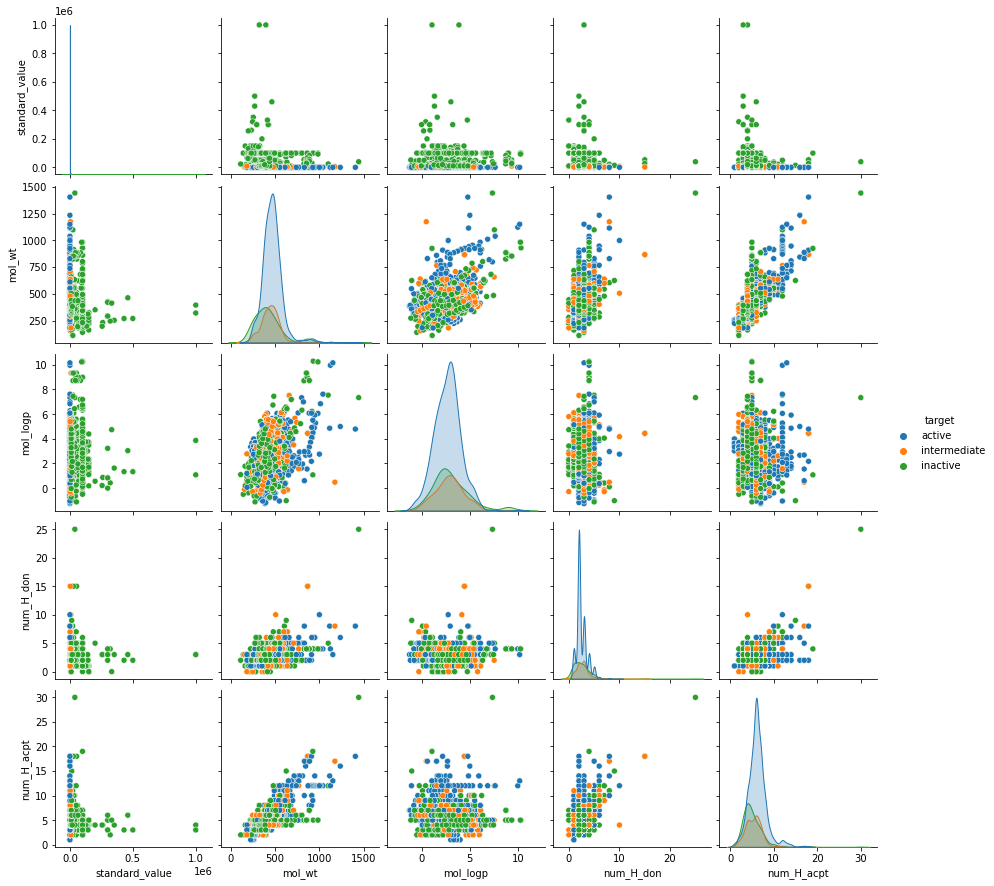

In [21]:
sns.pairplot(mmp_basic, hue='target')

array([[<AxesSubplot:title={'center':'standard_value'}>,
        <AxesSubplot:title={'center':'mol_wt'}>],
       [<AxesSubplot:title={'center':'mol_logp'}>,
        <AxesSubplot:title={'center':'num_H_don'}>],
       [<AxesSubplot:title={'center':'num_H_acpt'}>, <AxesSubplot:>]],
      dtype=object)

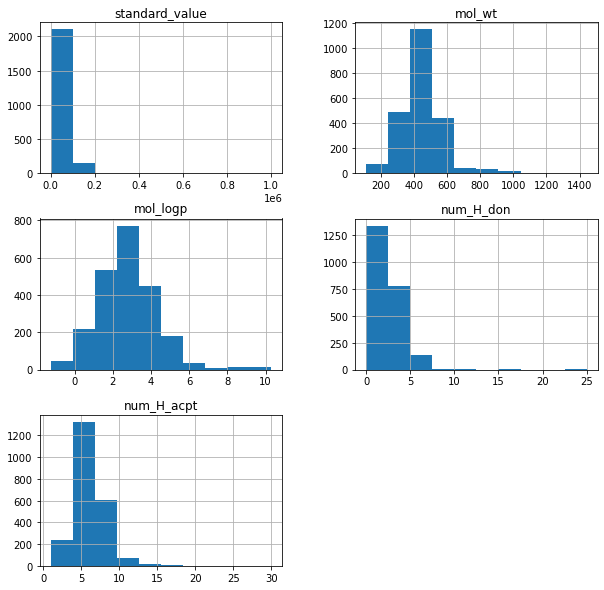

In [20]:
mmp_basic.hist(figsize=(10,10))

In [22]:
mmp_basic.to_csv('datasets/mmp_basic_lipinski.csv')

In [2]:
lipinski = pd.read_csv('datasets/mmp_basic_lipinski.csv')

In [4]:
lipinski

,Unnamed: 0,molecule_chembl_id,canonical_smiles,standard_value,target,mol_wt,mol_logp,num_H_don,num_H_acpt
0,0,CHEMBL80814,COc1ccc(CCN2CCC(C(=O)NO)(S(=O)(=O)c3ccc(OC)cc3...,34.0,active,448.541,2.06020,2.0,7.0
1,1,CHEMBL276119,COc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3cccc(OC)c3)...,9.0,active,434.514,2.01770,2.0,7.0
2,2,CHEMBL78934,CCCCOc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3ccc(Cl)c...,20.0,active,515.459,4.48620,2.0,6.0
3,3,CHEMBL78369,O=C(NO)C1(S(=O)(=O)c2ccc(OCc3ccccc3)cc2)CCN(Cc...,3.0,active,480.586,3.57950,2.0,6.0
4,4,CHEMBL514138,COc1ccc(S(=O)(=O)N(Cc2cccnc2)[C@@H](C(=O)NO)C(...,9.0,active,393.465,1.81110,2.0,6.0
...,...,...,...,...,...,...,...,...,...
2258,2258,CHEMBL4436740,Cc1cnc([C@]2(CNC(=O)c3cc4cc(C(F)(F)F)ccc4o3)NC...,64000.0,inactive,435.362,1.95822,3.0,6.0
2259,2259,CHEMBL4097165,O=C1NC(=O)[C@](CNC(=O)c2cc3cc(C(F)(F)F)ccc3o2)...,19000.0,inactive,381.310,2.16960,3.0,4.0
2260,2260,CHEMBL2402203,C[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)OCc1ccccc1)...,100000.0,inactive,386.423,2.56740,2.0,4.0
2261,2261,CHEMBL4590201,O=C(CF)CNC(=O)[C@H](Cc1ccccc1)NC(=O)c1ccccc1,100000.0,inactive,342.370,1.68250,2.0,3.0


Text(0, 0.5, 'IC50')

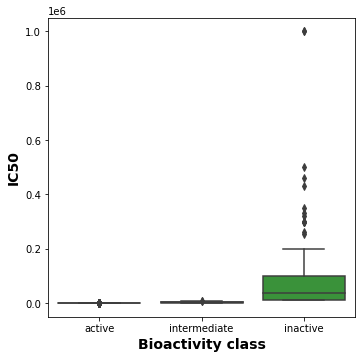

In [13]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'target', y = 'standard_value', data = lipinski)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('IC50', fontsize=14, fontweight='bold')

Text(0, 0.5, 'Molecular Weight')

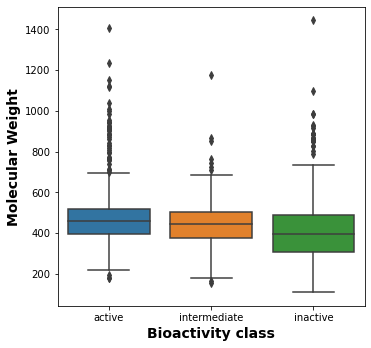

In [8]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'target', y = 'mol_wt', data = lipinski)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Molecular Weight', fontsize=14, fontweight='bold')

#plt.savefig('plot_MW.pdf') 

Text(0, 0.5, 'Molecular logP')

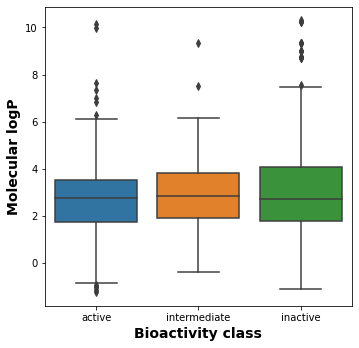

In [9]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'target', y = 'mol_logp', data = lipinski)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Molecular logP', fontsize=14, fontweight='bold')

#plt.savefig('plot_logP.pdf')

Text(0, 0.5, 'Number Hydrogen Donors')

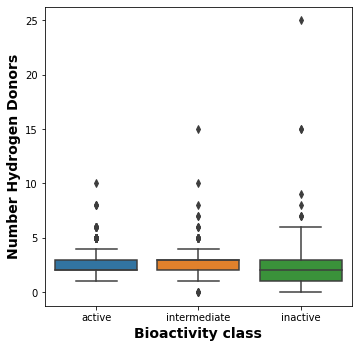

In [11]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'target', y = 'num_H_don', data = lipinski)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Number Hydrogen Donors', fontsize=14, fontweight='bold')

#plt.savefig('plot_H_donors.pdf')

Text(0, 0.5, 'Number Hydrogen Acceptors')

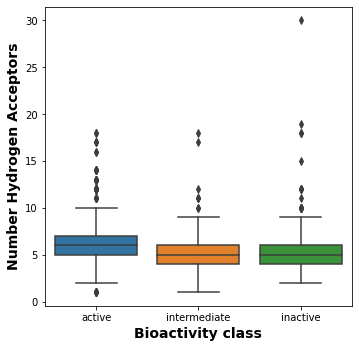

In [12]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'target', y = 'num_H_acpt', data = lipinski)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Number Hydrogen Acceptors', fontsize=14, fontweight='bold')

#plt.savefig('plot_H_accept.pdf')

In [15]:
from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu

def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/


# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'target']
  df = lipinski[selection]
  active = df[df['target'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'target']
  df = lipinski[selection]
  inactive = df[df['target'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  #results.to_csv(filename)

  return results

In [16]:

mannwhitney('mol_wt')

,Descriptor,Statistics,p,alpha,Interpretation
0,mol_wt,246423.0,1.328509e-22,0.05,Different distribution (reject H0)


In [17]:
mannwhitney('mol_logp')

,Descriptor,Statistics,p,alpha,Interpretation
0,mol_logp,324144.5,0.01098,0.05,Different distribution (reject H0)


In [18]:
mannwhitney('num_H_don')

,Descriptor,Statistics,p,alpha,Interpretation
0,num_H_don,330646.5,0.038315,0.05,Different distribution (reject H0)


In [19]:
mannwhitney('num_H_acpt')

,Descriptor,Statistics,p,alpha,Interpretation
0,num_H_acpt,219312.5,4.005972e-36,0.05,Different distribution (reject H0)


In [20]:
mannwhitney('standard_value')

,Descriptor,Statistics,p,alpha,Interpretation
0,standard_value,0.0,9.112962e-243,0.05,Different distribution (reject H0)


In [22]:
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

--2021-06-25 13:10:02--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
Resolving github.com... 140.82.113.3
Connecting to github.com|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip [following]
--2021-06-25 13:10:02--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip
Resolving raw.githubusercontent.com... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25768637 (25M) [application/zip]
Saving to: 'padel.zip'

padel.zip           100%[===================>]  24.57M  9.66MB/s    in 2.5s    

2021-06-25 13:10:05 (9.66 MB/s) - 'padel.zip' saved [25768637/25768637]

--2021-06-25 13:10:05--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh
Resolving github.com... 140

In [23]:

! unzip padel.zip

Archive:  padel.zip
  inflating: __MACOSX/._PaDEL-Descriptor  
  inflating: PaDEL-Descriptor/MACCSFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._MACCSFingerprinter.xml  
  inflating: PaDEL-Descriptor/AtomPairs2DFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._AtomPairs2DFingerprinter.xml  
  inflating: PaDEL-Descriptor/EStateFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._EStateFingerprinter.xml  
  inflating: PaDEL-Descriptor/Fingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._Fingerprinter.xml  
  inflating: PaDEL-Descriptor/.DS_Store  
  inflating: __MACOSX/PaDEL-Descriptor/._.DS_Store  
  inflating: __MACOSX/PaDEL-Descriptor/._license  
  inflating: PaDEL-Descriptor/KlekotaRothFingerprintCount.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._KlekotaRothFingerprintCount.xml  
  inflating: PaDEL-Descriptor/config  
  inflating: __MACOSX/PaDEL-Descriptor/._config  
  inflating: PaDEL-Descriptor/PubchemFingerprinter.xml  
  inflating: __MAC

In [26]:

selection = ['canonical_smiles','molecule_chembl_id']
for_modeling = lipinski[selection]
for_modeling.to_csv('datasets/molecule.smi', sep='\t', index=False, header=False)

In [27]:
! cat datasets/molecule.smi | head -5


COc1ccc(CCN2CCC(C(=O)NO)(S(=O)(=O)c3ccc(OC)cc3)CC2)cc1	CHEMBL80814
COc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3cccc(OC)c3)CC2)cc1	CHEMBL276119
CCCCOc1ccc(S(=O)(=O)C2(C(=O)NO)CCN(Cc3ccc(Cl)c(Cl)c3)CC2)cc1	CHEMBL78934
O=C(NO)C1(S(=O)(=O)c2ccc(OCc3ccccc3)cc2)CCN(Cc2ccccc2)CC1	CHEMBL78369
COc1ccc(S(=O)(=O)N(Cc2cccnc2)[C@@H](C(=O)NO)C(C)C)cc1	CHEMBL514138
cat: stdout: Broken pipe


In [28]:
! cat datasets/molecule.smi | wc -l


    2263


In [29]:
! cat padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv


In [32]:
! bash padel.sh

Processing CHEMBL80814 in molecule.smi (1/2263). 
Processing CHEMBL276119 in molecule.smi (2/2263). 
Processing CHEMBL78934 in molecule.smi (3/2263). 
Processing CHEMBL78369 in molecule.smi (4/2263). 
Processing CHEMBL80453 in molecule.smi (6/2263). Average speed: 2.85 s/mol.
Processing CHEMBL514138 in molecule.smi (5/2263). Average speed: 5.59 s/mol.
Processing CHEMBL312432 in molecule.smi (7/2263). Average speed: 1.98 s/mol.
Processing CHEMBL306617 in molecule.smi (8/2263). Average speed: 1.81 s/mol.
Processing CHEMBL79111 in molecule.smi (9/2263). Average speed: 1.48 s/mol.
Processing CHEMBL78798 in molecule.smi (10/2263). Average speed: 1.34 s/mol.
Processing CHEMBL80969 in molecule.smi (11/2263). Average speed: 1.24 s/mol.
Processing CHEMBL78909 in molecule.smi (12/2263). Average speed: 1.13 s/mol.
Processing CHEMBL76137 in molecule.smi (13/2263). Average speed: 1.02 s/mol.
Processing CHEMBL310340 in molecule.smi (14/2263). Average speed: 1.00 s/mol.
Processing CHEMBL440498 in mol

Processing CHEMBL80300 in molecule.smi (108/2263). Average speed: 0.36 s/mol.
Processing CHEMBL310655 in molecule.smi (109/2263). Average speed: 0.36 s/mol.
Processing CHEMBL308305 in molecule.smi (110/2263). Average speed: 0.36 s/mol.
Processing CHEMBL80894 in molecule.smi (111/2263). Average speed: 0.36 s/mol.
Processing CHEMBL90978 in molecule.smi (112/2263). Average speed: 0.36 s/mol.
Processing CHEMBL80322 in molecule.smi (113/2263). Average speed: 0.35 s/mol.
Processing CHEMBL76974 in molecule.smi (114/2263). Average speed: 0.35 s/mol.
Processing CHEMBL101121 in molecule.smi (115/2263). Average speed: 0.35 s/mol.
Processing CHEMBL297792 in molecule.smi (116/2263). Average speed: 0.35 s/mol.
Processing CHEMBL103442 in molecule.smi (117/2263). Average speed: 0.35 s/mol.
Processing CHEMBL155874 in molecule.smi (118/2263). Average speed: 0.34 s/mol.
Processing CHEMBL160461 in molecule.smi (119/2263). Average speed: 0.35 s/mol.
Processing CHEMBL160940 in molecule.smi (120/2263). Avera

Processing CHEMBL18943 in molecule.smi (213/2263). Average speed: 0.32 s/mol.
Processing CHEMBL305722 in molecule.smi (214/2263). Average speed: 0.31 s/mol.
Processing CHEMBL80565 in molecule.smi (215/2263). Average speed: 0.31 s/mol.
Processing CHEMBL3085155 in molecule.smi (216/2263). Average speed: 0.31 s/mol.
Processing CHEMBL310338 in molecule.smi (217/2263). Average speed: 0.31 s/mol.
Processing CHEMBL76356 in molecule.smi (218/2263). Average speed: 0.31 s/mol.
Processing CHEMBL18667 in molecule.smi (219/2263). Average speed: 0.31 s/mol.
Processing CHEMBL310688 in molecule.smi (220/2263). Average speed: 0.31 s/mol.
Processing CHEMBL80496 in molecule.smi (221/2263). Average speed: 0.31 s/mol.
Processing CHEMBL94363 in molecule.smi (222/2263). Average speed: 0.31 s/mol.
Processing CHEMBL278060 in molecule.smi (223/2263). Average speed: 0.31 s/mol.
Processing CHEMBL19005 in molecule.smi (225/2263). Average speed: 0.31 s/mol.
Processing CHEMBL76619 in molecule.smi (224/2263). Average

Processing CHEMBL366956 in molecule.smi (318/2263). Average speed: 0.26 s/mol.
Processing CHEMBL174641 in molecule.smi (319/2263). Average speed: 0.26 s/mol.
Processing CHEMBL176832 in molecule.smi (320/2263). Average speed: 0.26 s/mol.
Processing CHEMBL177740 in molecule.smi (321/2263). Average speed: 0.26 s/mol.
Processing CHEMBL176876 in molecule.smi (322/2263). Average speed: 0.26 s/mol.
Processing CHEMBL173075 in molecule.smi (323/2263). Average speed: 0.26 s/mol.
Processing CHEMBL329617 in molecule.smi (325/2263). Average speed: 0.26 s/mol.
Processing CHEMBL176467 in molecule.smi (324/2263). Average speed: 0.26 s/mol.
Processing CHEMBL367524 in molecule.smi (326/2263). Average speed: 0.26 s/mol.
Processing CHEMBL303666 in molecule.smi (327/2263). Average speed: 0.26 s/mol.
Processing CHEMBL19623 in molecule.smi (329/2263). Average speed: 0.25 s/mol.
Processing CHEMBL432842 in molecule.smi (328/2263). Average speed: 0.25 s/mol.
Processing CHEMBL19932 in molecule.smi (331/2263). Av

Processing CHEMBL48039 in molecule.smi (423/2263). Average speed: 0.24 s/mol.
Processing CHEMBL53840 in molecule.smi (424/2263). Average speed: 0.24 s/mol.
Processing CHEMBL58546 in molecule.smi (425/2263). Average speed: 0.24 s/mol.
Processing CHEMBL337042 in molecule.smi (426/2263). Average speed: 0.24 s/mol.
Processing CHEMBL134849 in molecule.smi (427/2263). Average speed: 0.24 s/mol.
Processing CHEMBL36999 in molecule.smi (428/2263). Average speed: 0.24 s/mol.
Processing CHEMBL291490 in molecule.smi (429/2263). Average speed: 0.24 s/mol.
Processing CHEMBL54176 in molecule.smi (430/2263). Average speed: 0.24 s/mol.
Processing CHEMBL59423 in molecule.smi (431/2263). Average speed: 0.24 s/mol.
Processing CHEMBL339381 in molecule.smi (432/2263). Average speed: 0.24 s/mol.
Processing CHEMBL296327 in molecule.smi (433/2263). Average speed: 0.24 s/mol.
Processing CHEMBL57551 in molecule.smi (434/2263). Average speed: 0.24 s/mol.
Processing CHEMBL36191 in molecule.smi (435/2263). Average 

Processing CHEMBL287632 in molecule.smi (528/2263). Average speed: 0.24 s/mol.
Processing CHEMBL311266 in molecule.smi (529/2263). Average speed: 0.24 s/mol.
Processing CHEMBL97034 in molecule.smi (530/2263). Average speed: 0.23 s/mol.
Processing CHEMBL96438 in molecule.smi (531/2263). Average speed: 0.23 s/mol.
Processing CHEMBL327262 in molecule.smi (532/2263). Average speed: 0.23 s/mol.
Processing CHEMBL421131 in molecule.smi (533/2263). Average speed: 0.23 s/mol.
Processing CHEMBL97709 in molecule.smi (534/2263). Average speed: 0.23 s/mol.
Processing CHEMBL329145 in molecule.smi (535/2263). Average speed: 0.23 s/mol.
Processing CHEMBL7390 in molecule.smi (536/2263). Average speed: 0.23 s/mol.
Processing CHEMBL424407 in molecule.smi (537/2263). Average speed: 0.23 s/mol.
Processing CHEMBL27408 in molecule.smi (538/2263). Average speed: 0.23 s/mol.
Processing CHEMBL83616 in molecule.smi (539/2263). Average speed: 0.23 s/mol.
Processing CHEMBL92512 in molecule.smi (540/2263). Average 

Processing CHEMBL349800 in molecule.smi (633/2263). Average speed: 0.23 s/mol.
Processing CHEMBL2112477 in molecule.smi (634/2263). Average speed: 0.23 s/mol.
Processing CHEMBL158571 in molecule.smi (635/2263). Average speed: 0.23 s/mol.
Processing CHEMBL352231 in molecule.smi (636/2263). Average speed: 0.23 s/mol.
Processing CHEMBL158823 in molecule.smi (637/2263). Average speed: 0.23 s/mol.
Processing CHEMBL347249 in molecule.smi (638/2263). Average speed: 0.23 s/mol.
Processing CHEMBL161562 in molecule.smi (639/2263). Average speed: 0.23 s/mol.
Processing CHEMBL436623 in molecule.smi (640/2263). Average speed: 0.23 s/mol.
Processing CHEMBL159033 in molecule.smi (641/2263). Average speed: 0.23 s/mol.
Processing CHEMBL345244 in molecule.smi (642/2263). Average speed: 0.23 s/mol.
Processing CHEMBL345640 in molecule.smi (643/2263). Average speed: 0.23 s/mol.
Processing CHEMBL158366 in molecule.smi (644/2263). Average speed: 0.23 s/mol.
Processing CHEMBL162128 in molecule.smi (645/2263).

Processing CHEMBL75302 in molecule.smi (738/2263). Average speed: 0.23 s/mol.
Processing CHEMBL307915 in molecule.smi (739/2263). Average speed: 0.23 s/mol.
Processing CHEMBL75139 in molecule.smi (740/2263). Average speed: 0.23 s/mol.
Processing CHEMBL77874 in molecule.smi (741/2263). Average speed: 0.23 s/mol.
Processing CHEMBL75164 in molecule.smi (742/2263). Average speed: 0.23 s/mol.
Processing CHEMBL73652 in molecule.smi (743/2263). Average speed: 0.23 s/mol.
Processing CHEMBL275654 in molecule.smi (744/2263). Average speed: 0.23 s/mol.
Processing CHEMBL100134 in molecule.smi (745/2263). Average speed: 0.23 s/mol.
Processing CHEMBL319887 in molecule.smi (746/2263). Average speed: 0.23 s/mol.
Processing CHEMBL102057 in molecule.smi (747/2263). Average speed: 0.23 s/mol.
Processing CHEMBL99745 in molecule.smi (748/2263). Average speed: 0.23 s/mol.
Processing CHEMBL101612 in molecule.smi (749/2263). Average speed: 0.23 s/mol.
Processing CHEMBL100564 in molecule.smi (750/2263). Averag

Processing CHEMBL379247 in molecule.smi (842/2263). Average speed: 0.22 s/mol.
Processing CHEMBL201298 in molecule.smi (843/2263). Average speed: 0.22 s/mol.
Processing CHEMBL202875 in molecule.smi (844/2263). Average speed: 0.22 s/mol.
Processing CHEMBL204593 in molecule.smi (845/2263). Average speed: 0.22 s/mol.
Processing CHEMBL378740 in molecule.smi (846/2263). Average speed: 0.22 s/mol.
Processing CHEMBL211037 in molecule.smi (847/2263). Average speed: 0.22 s/mol.
Processing CHEMBL206045 in molecule.smi (848/2263). Average speed: 0.22 s/mol.
Processing CHEMBL209465 in molecule.smi (849/2263). Average speed: 0.22 s/mol.
Processing CHEMBL377112 in molecule.smi (850/2263). Average speed: 0.22 s/mol.
Processing CHEMBL207026 in molecule.smi (851/2263). Average speed: 0.22 s/mol.
Processing CHEMBL208615 in molecule.smi (852/2263). Average speed: 0.22 s/mol.
Processing CHEMBL211036 in molecule.smi (853/2263). Average speed: 0.22 s/mol.
Processing CHEMBL379220 in molecule.smi (854/2263). 

Processing CHEMBL228187 in molecule.smi (947/2263). Average speed: 0.21 s/mol.
Processing CHEMBL227484 in molecule.smi (948/2263). Average speed: 0.21 s/mol.
Processing CHEMBL376557 in molecule.smi (949/2263). Average speed: 0.21 s/mol.
Processing CHEMBL374377 in molecule.smi (950/2263). Average speed: 0.21 s/mol.
Processing CHEMBL227598 in molecule.smi (951/2263). Average speed: 0.21 s/mol.
Processing CHEMBL227824 in molecule.smi (952/2263). Average speed: 0.21 s/mol.
Processing CHEMBL228231 in molecule.smi (953/2263). Average speed: 0.21 s/mol.
Processing CHEMBL388309 in molecule.smi (954/2263). Average speed: 0.21 s/mol.
Processing CHEMBL228229 in molecule.smi (956/2263). Average speed: 0.21 s/mol.
Processing CHEMBL228230 in molecule.smi (955/2263). Average speed: 0.21 s/mol.
Processing CHEMBL227566 in molecule.smi (957/2263). Average speed: 0.21 s/mol.
Processing CHEMBL226149 in molecule.smi (958/2263). Average speed: 0.21 s/mol.
Processing CHEMBL388982 in molecule.smi (959/2263). 

Processing CHEMBL402720 in molecule.smi (1052/2263). Average speed: 0.20 s/mol.
Processing CHEMBL442286 in molecule.smi (1053/2263). Average speed: 0.20 s/mol.
Processing CHEMBL252327 in molecule.smi (1054/2263). Average speed: 0.20 s/mol.
Processing CHEMBL404205 in molecule.smi (1055/2263). Average speed: 0.20 s/mol.
Processing CHEMBL252326 in molecule.smi (1056/2263). Average speed: 0.20 s/mol.
Processing CHEMBL254821 in molecule.smi (1057/2263). Average speed: 0.20 s/mol.
Processing CHEMBL398838 in molecule.smi (1058/2263). Average speed: 0.20 s/mol.
Processing CHEMBL254038 in molecule.smi (1060/2263). Average speed: 0.20 s/mol.
Processing CHEMBL254039 in molecule.smi (1059/2263). Average speed: 0.20 s/mol.
Processing CHEMBL253835 in molecule.smi (1061/2263). Average speed: 0.20 s/mol.
Processing CHEMBL253189 in molecule.smi (1062/2263). Average speed: 0.20 s/mol.
Processing CHEMBL253188 in molecule.smi (1063/2263). Average speed: 0.20 s/mol.
Processing CHEMBL399504 in molecule.smi 

Processing CHEMBL252020 in molecule.smi (1155/2263). Average speed: 0.20 s/mol.
Processing CHEMBL401404 in molecule.smi (1157/2263). Average speed: 0.20 s/mol.
Processing CHEMBL251821 in molecule.smi (1156/2263). Average speed: 0.20 s/mol.
Processing CHEMBL399566 in molecule.smi (1158/2263). Average speed: 0.20 s/mol.
Processing CHEMBL254506 in molecule.smi (1159/2263). Average speed: 0.20 s/mol.
Processing CHEMBL399565 in molecule.smi (1160/2263). Average speed: 0.20 s/mol.
Processing CHEMBL400785 in molecule.smi (1162/2263). Average speed: 0.20 s/mol.
Processing CHEMBL254293 in molecule.smi (1161/2263). Average speed: 0.20 s/mol.
Processing CHEMBL400193 in molecule.smi (1164/2263). Average speed: 0.20 s/mol.
Processing CHEMBL400784 in molecule.smi (1163/2263). Average speed: 0.20 s/mol.
Processing CHEMBL400192 in molecule.smi (1165/2263). Average speed: 0.20 s/mol.
Processing CHEMBL253242 in molecule.smi (1167/2263). Average speed: 0.20 s/mol.
Processing CHEMBL253450 in molecule.smi 

Processing CHEMBL523034 in molecule.smi (1258/2263). Average speed: 0.19 s/mol.
Processing CHEMBL460725 in molecule.smi (1260/2263). Average speed: 0.19 s/mol.
Processing CHEMBL455409 in molecule.smi (1259/2263). Average speed: 0.19 s/mol.
Processing CHEMBL460899 in molecule.smi (1261/2263). Average speed: 0.19 s/mol.
Processing CHEMBL180239 in molecule.smi (1262/2263). Average speed: 0.19 s/mol.
Processing CHEMBL116438 in molecule.smi (1263/2263). Average speed: 0.19 s/mol.
Processing CHEMBL481600 in molecule.smi (1264/2263). Average speed: 0.19 s/mol.
Processing CHEMBL481599 in molecule.smi (1265/2263). Average speed: 0.19 s/mol.
Processing CHEMBL473326 in molecule.smi (1266/2263). Average speed: 0.19 s/mol.
Processing CHEMBL500351 in molecule.smi (1267/2263). Average speed: 0.19 s/mol.
Processing CHEMBL448246 in molecule.smi (1268/2263). Average speed: 0.19 s/mol.
Processing CHEMBL475540 in molecule.smi (1269/2263). Average speed: 0.19 s/mol.
Processing CHEMBL488617 in molecule.smi 

Processing CHEMBL1090647 in molecule.smi (1361/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1093689 in molecule.smi (1362/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1093690 in molecule.smi (1363/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1092104 in molecule.smi (1364/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1089842 in molecule.smi (1365/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1089843 in molecule.smi (1366/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1088878 in molecule.smi (1367/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1085602 in molecule.smi (1368/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1082966 in molecule.smi (1369/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1083906 in molecule.smi (1370/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1083907 in molecule.smi (1371/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1084206 in molecule.smi (1372/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1084208 in 

Processing CHEMBL1801417 in molecule.smi (1463/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1801415 in molecule.smi (1464/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1801413 in molecule.smi (1465/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1801057 in molecule.smi (1466/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1801056 in molecule.smi (1467/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1801054 in molecule.smi (1468/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1801053 in molecule.smi (1469/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1801052 in molecule.smi (1470/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1229868 in molecule.smi (1471/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1801051 in molecule.smi (1472/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1801050 in molecule.smi (1473/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1801049 in molecule.smi (1474/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1801048 in 

Processing CHEMBL1933865 in molecule.smi (1565/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1933882 in molecule.smi (1566/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1939844 in molecule.smi (1567/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1939846 in molecule.smi (1569/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1939845 in molecule.smi (1568/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1939876 in molecule.smi (1570/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1940315 in molecule.smi (1571/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1940308 in molecule.smi (1572/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1940296 in molecule.smi (1573/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1796298 in molecule.smi (1574/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1940316 in molecule.smi (1575/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1940314 in molecule.smi (1576/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1940313 in 

Processing CHEMBL2151358 in molecule.smi (1667/2263). Average speed: 0.19 s/mol.
Processing CHEMBL2151359 in molecule.smi (1668/2263). Average speed: 0.19 s/mol.
Processing CHEMBL2151360 in molecule.smi (1669/2263). Average speed: 0.19 s/mol.
Processing CHEMBL2151361 in molecule.smi (1670/2263). Average speed: 0.19 s/mol.
Processing CHEMBL2151362 in molecule.smi (1671/2263). Average speed: 0.19 s/mol.
Processing CHEMBL2151363 in molecule.smi (1672/2263). Average speed: 0.19 s/mol.
Processing CHEMBL2151364 in molecule.smi (1673/2263). Average speed: 0.19 s/mol.
Processing CHEMBL2151365 in molecule.smi (1674/2263). Average speed: 0.19 s/mol.
Processing CHEMBL2203641 in molecule.smi (1675/2263). Average speed: 0.19 s/mol.
Processing CHEMBL2203640 in molecule.smi (1676/2263). Average speed: 0.19 s/mol.
Processing CHEMBL2203639 in molecule.smi (1677/2263). Average speed: 0.19 s/mol.
Processing CHEMBL2203638 in molecule.smi (1678/2263). Average speed: 0.19 s/mol.
Processing CHEMBL2203637 in 

Processing CHEMBL1165152 in molecule.smi (1769/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1163455 in molecule.smi (1770/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1163454 in molecule.smi (1771/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1165627 in molecule.smi (1772/2263). Average speed: 0.19 s/mol.
Processing CHEMBL69803 in molecule.smi (1773/2263). Average speed: 0.19 s/mol.
Processing CHEMBL68427 in molecule.smi (1774/2263). Average speed: 0.19 s/mol.
Processing CHEMBL421295 in molecule.smi (1775/2263). Average speed: 0.19 s/mol.
Processing CHEMBL67498 in molecule.smi (1776/2263). Average speed: 0.19 s/mol.
Processing CHEMBL67291 in molecule.smi (1777/2263). Average speed: 0.19 s/mol.
Processing CHEMBL275362 in molecule.smi (1778/2263). Average speed: 0.19 s/mol.
Processing CHEMBL323612 in molecule.smi (1779/2263). Average speed: 0.19 s/mol.
Processing CHEMBL2385451 in molecule.smi (1780/2263). Average speed: 0.19 s/mol.
Processing CHEMBL2385450 in molecule.sm

Processing CHEMBL3098985 in molecule.smi (1871/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3099031 in molecule.smi (1872/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3099030 in molecule.smi (1873/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3099029 in molecule.smi (1874/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3099028 in molecule.smi (1875/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3099020 in molecule.smi (1876/2263). Average speed: 0.19 s/mol.
Processing CHEMBL87223 in molecule.smi (1877/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3221177 in molecule.smi (1878/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3221178 in molecule.smi (1879/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3221179 in molecule.smi (1880/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3221863 in molecule.smi (1881/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3221864 in molecule.smi (1882/2263). Average speed: 0.19 s/mol.
Processing CHEMBL489100 in mol

Processing CHEMBL3751997 in molecule.smi (1974/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3752419 in molecule.smi (1975/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3754094 in molecule.smi (1976/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3753984 in molecule.smi (1977/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3751971 in molecule.smi (1978/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3752374 in molecule.smi (1979/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3754100 in molecule.smi (1980/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3752513 in molecule.smi (1981/2263). Average speed: 0.19 s/mol.
Processing CHEMBL1229516 in molecule.smi (1982/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3770935 in molecule.smi (1983/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3770688 in molecule.smi (1984/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3792916 in molecule.smi (1985/2263). Average speed: 0.19 s/mol.
Processing CHEMBL3792842 in 

Processing CHEMBL4177034 in molecule.smi (2076/2263). Average speed: 0.19 s/mol.
Processing CHEMBL4165747 in molecule.smi (2077/2263). Average speed: 0.19 s/mol.
Processing CHEMBL4173661 in molecule.smi (2078/2263). Average speed: 0.19 s/mol.
Processing CHEMBL4175968 in molecule.smi (2079/2263). Average speed: 0.19 s/mol.
Processing CHEMBL4165348 in molecule.smi (2080/2263). Average speed: 0.19 s/mol.
Processing CHEMBL4172564 in molecule.smi (2081/2263). Average speed: 0.19 s/mol.
Processing CHEMBL4161914 in molecule.smi (2082/2263). Average speed: 0.19 s/mol.
Processing CHEMBL4164242 in molecule.smi (2083/2263). Average speed: 0.19 s/mol.
Processing CHEMBL4172116 in molecule.smi (2084/2263). Average speed: 0.19 s/mol.
Processing CHEMBL4167168 in molecule.smi (2085/2263). Average speed: 0.19 s/mol.
Processing CHEMBL4159255 in molecule.smi (2086/2263). Average speed: 0.19 s/mol.
Processing CHEMBL4170562 in molecule.smi (2087/2263). Average speed: 0.19 s/mol.
Processing CHEMBL4162629 in 

Processing CHEMBL4245382 in molecule.smi (2178/2263). Average speed: 0.20 s/mol.
Processing CHEMBL4291062 in molecule.smi (2179/2263). Average speed: 0.20 s/mol.
Processing CHEMBL4285838 in molecule.smi (2180/2263). Average speed: 0.20 s/mol.
Processing CHEMBL4278980 in molecule.smi (2181/2263). Average speed: 0.20 s/mol.
Processing CHEMBL4289657 in molecule.smi (2182/2263). Average speed: 0.20 s/mol.
Processing CHEMBL4294130 in molecule.smi (2183/2263). Average speed: 0.20 s/mol.
Processing CHEMBL4286237 in molecule.smi (2184/2263). Average speed: 0.20 s/mol.
Processing CHEMBL4290729 in molecule.smi (2185/2263). Average speed: 0.20 s/mol.
Processing CHEMBL4282849 in molecule.smi (2186/2263). Average speed: 0.20 s/mol.
Processing CHEMBL4291027 in molecule.smi (2188/2263). Average speed: 0.20 s/mol.
Processing CHEMBL4283171 in molecule.smi (2187/2263). Average speed: 0.20 s/mol.
Processing CHEMBL4279699 in molecule.smi (2189/2263). Average speed: 0.20 s/mol.
Processing CHEMBL500586 in m

In [4]:
df3_X = pd.read_csv('datasets/descriptors_output.csv')

In [4]:
df3_X.head()

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL276119,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL80814,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL78934,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL78369,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL514138,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
for x in df3_X.columns:
    print(df3_X[x].value_counts(normalize=True))

CHEMBL3828051    0.000442
CHEMBL2096854    0.000442
CHEMBL125104     0.000442
CHEMBL2096739    0.000442
CHEMBL2043294    0.000442
                   ...   
CHEMBL436324     0.000442
CHEMBL399997     0.000442
CHEMBL1427458    0.000442
CHEMBL76888      0.000442
CHEMBL2063429    0.000442
Name: Name, Length: 2263, dtype: float64
1    1.0
Name: PubchemFP0, dtype: float64
1    0.996023
0    0.003977
Name: PubchemFP1, dtype: float64
1    0.869642
0    0.130358
Name: PubchemFP2, dtype: float64
0    0.826337
1    0.173663
Name: PubchemFP3, dtype: float64
0    1.0
Name: PubchemFP4, dtype: float64
0    1.0
Name: PubchemFP5, dtype: float64
0    1.0
Name: PubchemFP6, dtype: float64
0    1.0
Name: PubchemFP7, dtype: float64
0    1.0
Name: PubchemFP8, dtype: float64
1    0.999558
0    0.000442
Name: PubchemFP9, dtype: float64
1    0.998674
0    0.001326
Name: PubchemFP10, dtype: float64
1    0.98365
0    0.01635
Name: PubchemFP11, dtype: float64
1    0.863014
0    0.136986
Name: PubchemFP12, dtype: f

Name: PubchemFP161, dtype: float64
0    1.0
Name: PubchemFP162, dtype: float64
0    1.0
Name: PubchemFP163, dtype: float64
0    1.0
Name: PubchemFP164, dtype: float64
0    1.0
Name: PubchemFP165, dtype: float64
0    1.0
Name: PubchemFP166, dtype: float64
0    1.0
Name: PubchemFP167, dtype: float64
0    1.0
Name: PubchemFP168, dtype: float64
0    1.0
Name: PubchemFP169, dtype: float64
0    1.0
Name: PubchemFP170, dtype: float64
0    1.0
Name: PubchemFP171, dtype: float64
0    1.0
Name: PubchemFP172, dtype: float64
0    1.0
Name: PubchemFP173, dtype: float64
0    1.0
Name: PubchemFP174, dtype: float64
0    1.0
Name: PubchemFP175, dtype: float64
0    1.0
Name: PubchemFP176, dtype: float64
0    1.0
Name: PubchemFP177, dtype: float64
1    0.97658
0    0.02342
Name: PubchemFP178, dtype: float64
1    0.954043
0    0.045957
Name: PubchemFP179, dtype: float64
0    0.543526
1    0.456474
Name: PubchemFP180, dtype: float64
0    0.512594
1    0.487406
Name: PubchemFP181, dtype: float64
0    0.9977

Name: PubchemFP367, dtype: float64
0    0.73133
1    0.26867
Name: PubchemFP368, dtype: float64
0    0.999558
1    0.000442
Name: PubchemFP369, dtype: float64
1    0.961555
0    0.038445
Name: PubchemFP370, dtype: float64
1    0.95316
0    0.04684
Name: PubchemFP371, dtype: float64
0    0.836942
1    0.163058
Name: PubchemFP372, dtype: float64
0    0.835175
1    0.164825
Name: PubchemFP373, dtype: float64
1    0.68935
0    0.31065
Name: PubchemFP374, dtype: float64
0    0.831639
1    0.168361
Name: PubchemFP375, dtype: float64
0    0.566063
1    0.433937
Name: PubchemFP376, dtype: float64
0    0.676977
1    0.323023
Name: PubchemFP377, dtype: float64
0    0.981441
1    0.018559
Name: PubchemFP378, dtype: float64
0    0.957137
1    0.042863
Name: PubchemFP379, dtype: float64
0    0.769775
1    0.230225
Name: PubchemFP380, dtype: float64
1    0.60981
0    0.39019
Name: PubchemFP381, dtype: float64
1    0.590367
0    0.409633
Name: PubchemFP382, dtype: float64
1    0.589041
0    0.410959


0    0.69863
1    0.30137
Name: PubchemFP538, dtype: float64
0    0.703933
1    0.296067
Name: PubchemFP539, dtype: float64
1    0.766681
0    0.233319
Name: PubchemFP540, dtype: float64
1    0.60053
0    0.39947
Name: PubchemFP541, dtype: float64
1    0.587715
0    0.412285
Name: PubchemFP542, dtype: float64
0    0.967742
1    0.032258
Name: PubchemFP543, dtype: float64
0    0.972161
1    0.027839
Name: PubchemFP544, dtype: float64
0    0.52806
1    0.47194
Name: PubchemFP545, dtype: float64
0    0.580645
1    0.419355
Name: PubchemFP546, dtype: float64
0    0.948741
1    0.051259
Name: PubchemFP547, dtype: float64
1    0.638975
0    0.361025
Name: PubchemFP548, dtype: float64
1    0.620415
0    0.379585
Name: PubchemFP549, dtype: float64
0    0.920901
1    0.079099
Name: PubchemFP550, dtype: float64
0    1.0
Name: PubchemFP551, dtype: float64
1    0.956253
0    0.043747
Name: PubchemFP552, dtype: float64
0    0.646045
1    0.353955
Name: PubchemFP553, dtype: float64
0    0.949624
1  

0    0.939019
1    0.060981
Name: PubchemFP686, dtype: float64
0    0.888202
1    0.111798
Name: PubchemFP687, dtype: float64
1    0.793637
0    0.206363
Name: PubchemFP688, dtype: float64
1    0.692886
0    0.307114
Name: PubchemFP689, dtype: float64
0    0.96951
1    0.03049
Name: PubchemFP690, dtype: float64
0    0.809545
1    0.190455
Name: PubchemFP691, dtype: float64
1    0.517897
0    0.482103
Name: PubchemFP692, dtype: float64
0    0.912064
1    0.087936
Name: PubchemFP693, dtype: float64
0    0.94388
1    0.05612
Name: PubchemFP694, dtype: float64
0    0.783031
1    0.216969
Name: PubchemFP695, dtype: float64
1    0.567388
0    0.432612
Name: PubchemFP696, dtype: float64
0    0.524083
1    0.475917
Name: PubchemFP697, dtype: float64
0    0.724702
1    0.275298
Name: PubchemFP698, dtype: float64
0    0.770658
1    0.229342
Name: PubchemFP699, dtype: float64
0    0.973928
1    0.026072
Name: PubchemFP700, dtype: float64
0    0.972603
1    0.027397
Name: PubchemFP701, dtype: floa

Name: PubchemFP846, dtype: float64
0    1.0
Name: PubchemFP847, dtype: float64
0    1.0
Name: PubchemFP848, dtype: float64
0    1.0
Name: PubchemFP849, dtype: float64
0    1.0
Name: PubchemFP850, dtype: float64
0    1.0
Name: PubchemFP851, dtype: float64
0    1.0
Name: PubchemFP852, dtype: float64
0    1.0
Name: PubchemFP853, dtype: float64
0    1.0
Name: PubchemFP854, dtype: float64
0    1.0
Name: PubchemFP855, dtype: float64
0    1.0
Name: PubchemFP856, dtype: float64
0    1.0
Name: PubchemFP857, dtype: float64
0    1.0
Name: PubchemFP858, dtype: float64
0    1.0
Name: PubchemFP859, dtype: float64
0    0.986743
1    0.013257
Name: PubchemFP860, dtype: float64
0    0.999558
1    0.000442
Name: PubchemFP861, dtype: float64
0    0.984534
1    0.015466
Name: PubchemFP862, dtype: float64
0    0.981882
1    0.018118
Name: PubchemFP863, dtype: float64
0    1.0
Name: PubchemFP864, dtype: float64
0    1.0
Name: PubchemFP865, dtype: float64
0    0.999558
1    0.000442
Name: PubchemFP866, dtype

In [5]:
X=df3_X.drop('Name', axis=1)

In [6]:
lipinski = pd.read_csv('datasets/mmp_basic_lipinski.csv')

In [20]:
y = lipinski['target']
y.where(y=='active', 'inactive', inplace=True)
y.value_counts(normalize=True)

active     0.61
inactive   0.39
Name: target, dtype: float64

In [22]:
y = y.map({'active':1, 'inactive':0})
y

0       1
1       1
2       1
3       1
4       1
       ..
2258    0
2259    0
2260    0
2261    0
2262    0
Name: target, Length: 2263, dtype: int64

In [7]:
X.shape

(2263, 881)

In [23]:
# Separate data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [24]:
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X_train = selection.fit_transform(X_train)
X_test = selection.transform(X_test)

In [10]:
X_train.shape

(1810, 148)

In [25]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:12<00:00,  2.24it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.82,0.79,0.79,0.81,0.57
RandomForestClassifier,0.80,0.79,0.79,0.80,0.45
XGBClassifier,0.80,0.79,0.79,0.80,0.95
LGBMClassifier,0.80,0.79,0.79,0.80,0.86
NuSVC,0.81,0.79,0.79,0.81,1.07
KNeighborsClassifier,0.80,0.79,0.79,0.80,0.23
BaggingClassifier,0.79,0.78,0.78,0.79,0.48
LinearSVC,0.80,0.78,0.78,0.79,1.72
RidgeClassifier,0.80,0.78,0.78,0.79,0.05


In [44]:
def evaluate(model, X_train, X_test, y_train, y_test, use_decision_function='yes'):
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 5))
    
    train_pred = model.predict(X_train)
    cm_train = confusion_matrix(y_train, train_pred, labels=[0,1])
    disp_train = ConfusionMatrixDisplay(cm_train, display_labels=['inactive','active'])
    disp_train.plot(ax=ax1, cmap='Blues')
    ax1.set_title('Train Matrix')
    
    
    test_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, test_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(cm, display_labels=['inactive','active'])
    disp.plot(ax=ax2, cmap='Blues')
    ax2.set_title('Test Matrix')
    plt.show()
    
    if use_decision_function == 'skip': # skips calculating the roc_auc_score
        train_out = False
        test_out = False
    elif use_decision_function == 'yes': # not all classifiers have decision_function
        train_out = model.decision_function(X_train)
        test_out = model.decision_function(X_test)
    elif use_decision_function == 'no':
        train_out = model.predict_proba(X_train)[:, 1] # proba for the 1 class
        test_out = model.predict_proba(X_test)[:, 1]
    else:
        raise Exception ("The value for use_decision_function should be 'skip', 'yes' or 'no'.")
    
    train_acc = accuracy_score(y_train, train_pred) 
    train_roc_auc = roc_auc_score(y_train, train_out)
    train_precision, train_recall, train_fscore, support = precision_recall_fscore_support(y_train, 
                                                                                           train_pred, 
                                                                                           average='weighted')
    print('Train scores:')
    print(f'Accuracy: {train_acc: .3f}, ROC/AUC: {train_roc_auc: .3f}')
    print(f'Precision: {train_precision: .3f}, Recall: {train_recall: .3f}, F1 Score: {train_fscore: .3f}')

    test_acc = accuracy_score(y_test, test_pred) 
    test_roc_auc = roc_auc_score(y_test, test_out)
    test_precision, test_recall, test_fscore, support = precision_recall_fscore_support(y_test, 
                                                                                        test_pred, 
                                                                                        average='weighted')
    print('Test scores:')
    print(f'Accuracy: {test_acc: .3f}, ROC/AUC: {test_roc_auc: .3f}')
    print(f'Precision: {test_precision: .3f}, Recall: {test_recall: .3f}, F1 Score: {test_fscore: .3f}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.479643
0:	learn: 0.5661895	total: 11.6ms	remaining: 221ms
1:	learn: 0.5067062	total: 21.5ms	remaining: 194ms
2:	learn: 0.4688358	total: 31.2ms	remaining: 177ms
3:	learn: 0.4402017	total: 39.3ms	remaining: 157ms
4:	learn: 0.4223833	total: 47.9ms	remaining: 144ms
5:	learn: 0.4052025	total: 59ms	remaining: 138ms
6:	learn: 0.3888517	total: 80.5ms	remaining: 150ms
7:	learn: 0.3794422	total: 93.1ms	remaining: 140ms
8:	learn: 0.3701394	total: 106ms	remaining: 129ms
9:	learn: 0.3599663	total: 141ms	remaining: 141ms
10:	learn: 0.3514591	total: 166ms	remaining: 136ms
11:	learn: 0.3406316	total: 180ms	remaining: 120ms
12:	learn: 0.3339465	total: 195ms	remaining: 105ms
13:	learn: 0.3262351	total: 207ms	remaining: 88.7ms
14:	learn: 0.3193211	total: 217ms	remaining: 72.5ms
15:	learn: 0.3123152	total: 230ms	remaining: 57.5ms
16:	learn: 0.3080200	total: 246ms	remaining: 43.4ms
17:	learn: 0.3008595	total: 259ms	remaining: 28.8ms
18:	learn: 0.2927445	total: 269ms	remaining: 14.1ms

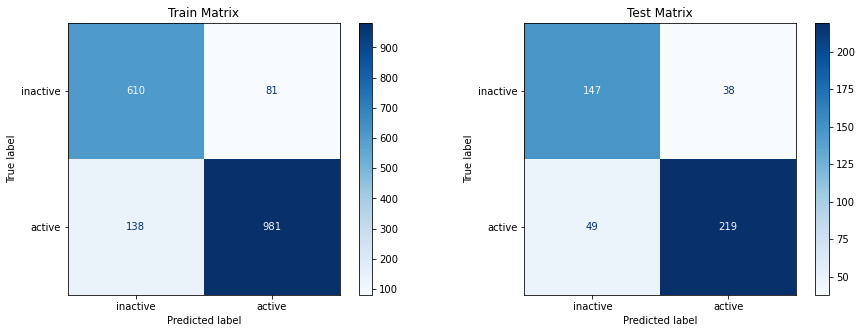

Train scores:
Accuracy:  0.879, ROC/AUC:  0.958
Precision:  0.882, Recall:  0.879, F1 Score:  0.880
Test scores:
Accuracy:  0.808, ROC/AUC:  0.882
Precision:  0.810, Recall:  0.808, F1 Score:  0.809


In [30]:
catboost = CatBoostClassifier(iterations=20, auto_class_weights='Balanced')

catboost.fit(X_train, y_train, plot=True)
evaluate(catboost, X_train, X_test, y_train, y_test, 'no')

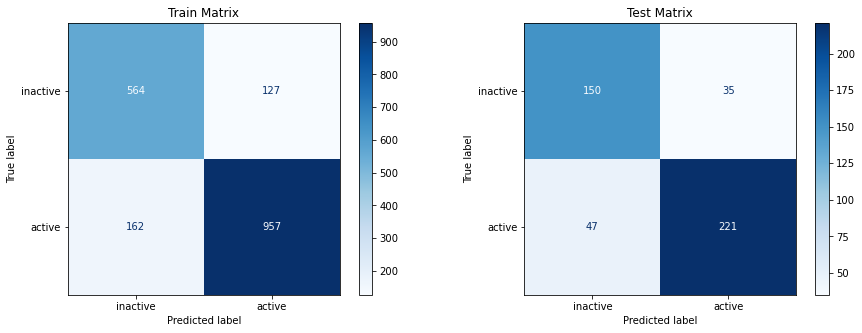

Train scores:
Accuracy:  0.840, ROC/AUC:  0.922
Precision:  0.842, Recall:  0.840, F1 Score:  0.841
Test scores:
Accuracy:  0.819, ROC/AUC:  0.890
Precision:  0.822, Recall:  0.819, F1 Score:  0.820


In [31]:
svc = SVC(class_weight='balanced', random_state=6)
svc_1 = svc.fit(X_train, y_train)
evaluate(svc_1, X_train, X_test, y_train, y_test)

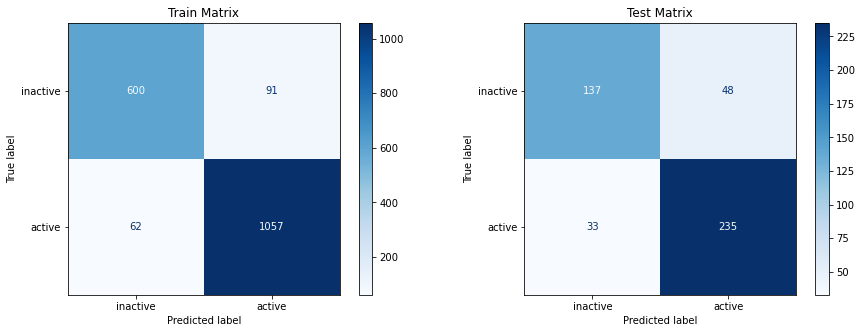

Train scores:
Accuracy:  0.915, ROC/AUC:  0.976
Precision:  0.915, Recall:  0.915, F1 Score:  0.915
Test scores:
Accuracy:  0.821, ROC/AUC:  0.891
Precision:  0.820, Recall:  0.821, F1 Score:  0.820


In [34]:
rfc = RandomForestClassifier(max_depth=10, class_weight='balanced', random_state=6)
rfc_1 = rfc.fit(X_train, y_train)
evaluate(rfc_1, X_train, X_test, y_train, y_test, 'no')

In [78]:
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 6,
 'verbose': 0,
 'warm_start': False}

In [45]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform

In [46]:

criterion = ['gini', 'entropy']
max_depth = list(range(1, 51))

min_samples_leaf = list(range(1, 6))
min_samples_split = list(range(1, 11))
n_estimators = list(range(25, 225, 25))




params = [{'criterion': criterion, 'max_depth': max_depth, 
           'min_samples_leaf': min_samples_leaf, 'min_samples_split': min_samples_split, 
           'n_estimators': n_estimators}]

rfc_2 = RandomForestClassifier(class_weight='balanced', random_state=6)
rs_rfc_2 = RandomizedSearchCV(rfc_2, params, scoring='f1_weighted', cv=5, verbose=1, random_state=6)
rs_rfc_2.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   17.4s finished


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=6),
                   param_distributions=[{'criterion': ['gini', 'entropy'],
                                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8,
                                                       9, 10, 11, 12, 13, 14,
                                                       15, 16, 17, 18, 19, 20,
                                                       21, 22, 23, 24, 25, 26,
                                                       27, 28, 29, 30, ...],
                                         'min_samples_leaf': [1, 2, 3, 4, 5],
                                         'min_samples_split': [1, 2, 3, 4, 5, 6,
                                                               7, 8, 9, 10],
                                         'n_estimators': [25, 50, 75, 100, 125,
                                              

In [47]:
rs_rfc_2.best_params_

{'n_estimators': 200,
 'min_samples_split': 6,
 'min_samples_leaf': 2,
 'max_depth': 48,
 'criterion': 'gini'}

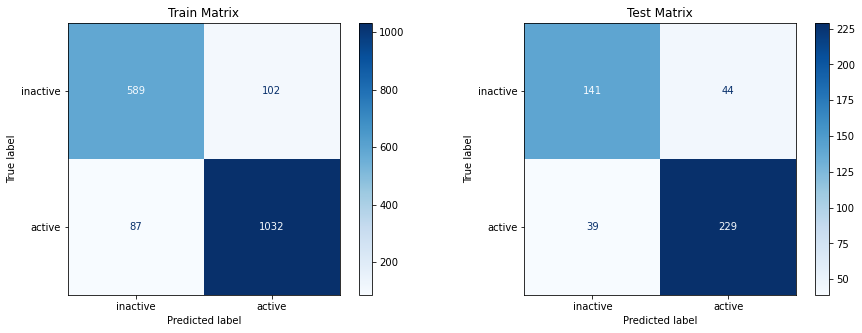

Train scores:
Accuracy:  0.896, ROC/AUC:  0.965
Precision:  0.895, Recall:  0.896, F1 Score:  0.895
Test scores:
Accuracy:  0.817, ROC/AUC:  0.892
Precision:  0.816, Recall:  0.817, F1 Score:  0.816


In [48]:
evaluate(rs_rfc_2.best_estimator_, X_train, X_test, y_train, y_test, 'no')

In [49]:
criterion = ['gini', 'entropy']
max_depth = [ 44, 46, 48, 50, 52]

min_samples_leaf = [1, 2, 3, 4]
min_samples_split = [4, 5, 6, 7, 8]
n_estimators = [150, 175, 200, 225, 250]




params = [{'criterion': criterion, 'max_depth': max_depth, 
           'min_samples_leaf': min_samples_leaf, 'min_samples_split': min_samples_split, 
           'n_estimators': n_estimators}]

rfc_3 = RandomForestClassifier(class_weight='balanced', random_state=6)
gs_rfc_3 = GridSearchCV(rfc_3, params, scoring='precision_weighted', cv=5, verbose=1)
gs_rfc_3.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed: 64.2min finished


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=6),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [44, 46, 48, 50, 52],
                          'min_samples_leaf': [1, 2, 3, 4],
                          'min_samples_split': [4, 5, 6, 7, 8],
                          'n_estimators': [150, 175, 200, 225, 250]}],
             scoring='precision_weighted', verbose=1)

In [50]:
gs_rfc_3.best_params_

{'criterion': 'entropy',
 'max_depth': 44,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 150}

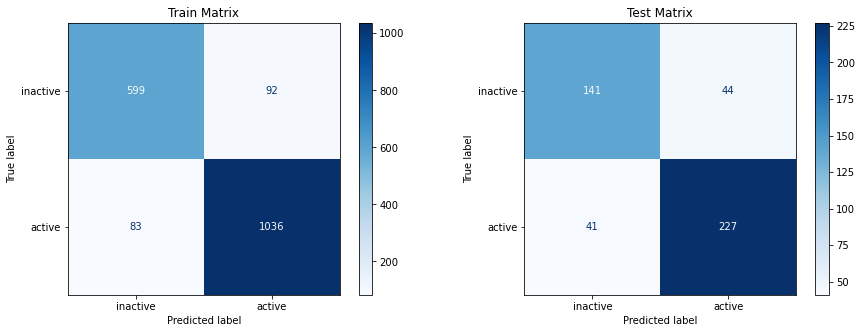

Train scores:
Accuracy:  0.903, ROC/AUC:  0.970
Precision:  0.903, Recall:  0.903, F1 Score:  0.903
Test scores:
Accuracy:  0.812, ROC/AUC:  0.891
Precision:  0.812, Recall:  0.812, F1 Score:  0.812


In [51]:
evaluate(gs_rfc_3.best_estimator_, X_train, X_test, y_train, y_test, 'no')

In [52]:
criterion = ['gini']
max_depth = [ 44, 46, 48, 50, 52]

min_samples_leaf = [1, 2, 3, 4]
min_samples_split = [4, 5, 6, 7, 8]
n_estimators = [150, 175, 200, 225, 250]




params = [{'criterion': criterion, 'max_depth': max_depth, 
           'min_samples_leaf': min_samples_leaf, 'min_samples_split': min_samples_split, 
           'n_estimators': n_estimators}]

rfc_4 = RandomForestClassifier(class_weight='balanced', random_state=6)
gs_rfc_4 = GridSearchCV(rfc_4, params, scoring='precision_weighted', cv=5, verbose=1)
gs_rfc_4.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed: 34.2min finished


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=6),
             param_grid=[{'criterion': ['gini'],
                          'max_depth': [44, 46, 48, 50, 52],
                          'min_samples_leaf': [1, 2, 3, 4],
                          'min_samples_split': [4, 5, 6, 7, 8],
                          'n_estimators': [150, 175, 200, 225, 250]}],
             scoring='precision_weighted', verbose=1)

In [53]:
gs_rfc_4.best_params_

{'criterion': 'gini',
 'max_depth': 44,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 250}

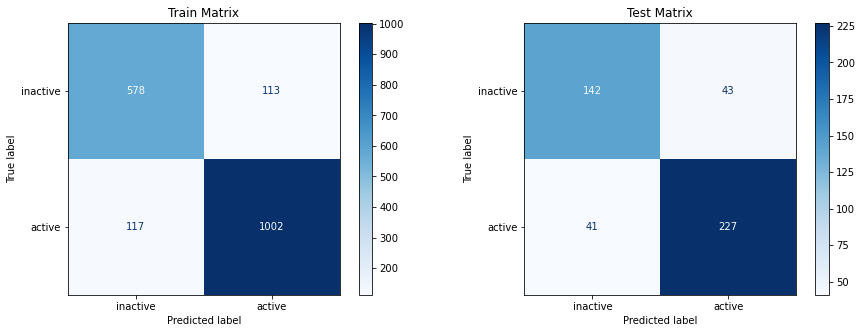

Train scores:
Accuracy:  0.873, ROC/AUC:  0.952
Precision:  0.873, Recall:  0.873, F1 Score:  0.873
Test scores:
Accuracy:  0.815, ROC/AUC:  0.891
Precision:  0.814, Recall:  0.815, F1 Score:  0.814


In [54]:
evaluate(gs_rfc_4.best_estimator_, X_train, X_test, y_train, y_test, 'no')

In [59]:

max_depth = list(range(5, 50))





params = [{'max_depth': max_depth}]

rfc_5 = RandomForestClassifier(class_weight='balanced', random_state=6)
gs_rfc_5 = GridSearchCV(rfc_5, params, scoring='f1_weighted', cv=5, verbose=1)
gs_rfc_5.fit(X_train, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:  1.4min finished


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=6),
             param_grid=[{'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                                        16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
                                        26, 27, 28, 29, 30, 31, 32, 33, 34, ...]}],
             scoring='f1_weighted', verbose=1)

In [60]:
gs_rfc_5.best_params_

{'max_depth': 12}

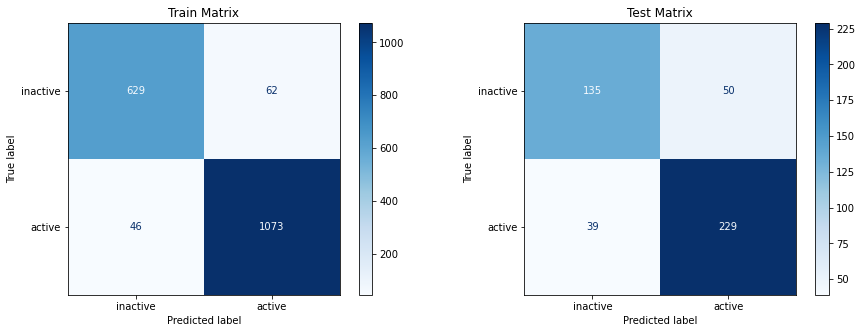

Train scores:
Accuracy:  0.940, ROC/AUC:  0.988
Precision:  0.940, Recall:  0.940, F1 Score:  0.940
Test scores:
Accuracy:  0.804, ROC/AUC:  0.882
Precision:  0.802, Recall:  0.804, F1 Score:  0.802


In [61]:
evaluate(gs_rfc_5.best_estimator_, X_train, X_test, y_train, y_test, 'no')

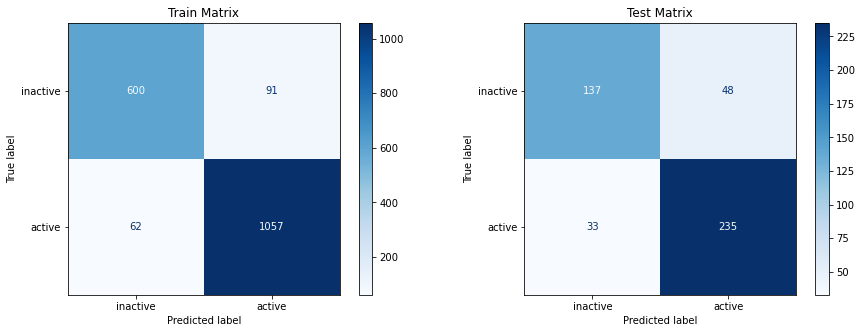

Train scores:
Accuracy:  0.915, ROC/AUC:  0.976
Precision:  0.915, Recall:  0.915, F1 Score:  0.915
Test scores:
Accuracy:  0.821, ROC/AUC:  0.891
Precision:  0.820, Recall:  0.821, F1 Score:  0.820


In [58]:
rfc_6 = RandomForestClassifier(max_depth=10, class_weight='balanced', random_state=6)
rfc_6 = rfc_6.fit(X_train, y_train)
evaluate(rfc_6, X_train, X_test, y_train, y_test, 'no')